In [1]:
import csv
import numpy as np
import pandas
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
#Reading the data
training_examples = pandas.read_csv("C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Data\\Features\\Training\\AllFeaturesv4.csv")
training_examples = training_examples.drop('CustomerAdd.y', axis=1)
training_examples = training_examples.drop('ym', axis=1)
training_examples_tpid = training_examples[["FinalTPID"]]
training_examples = training_examples.drop('FinalTPID', axis=1)

training_labels = training_examples[["CustomerAdd.x"]]
training_examples = training_examples.drop('CustomerAdd.x', axis=1)

#training_examples = training_examples.iloc[:,0:200]
print(len(training_examples.columns))
print (training_examples.columns)

# Adding some new % features 
training_examples['AnnuityPercentage'] = training_examples['Annuity']/(training_examples['Annuity'] + training_examples['NonAnnuity']
                                                                      + training_examples['DarkAnnuity'])
training_examples['NonAnnuityPercentage'] = training_examples['NonAnnuity']/(training_examples['Annuity'] + training_examples['NonAnnuity']
                                                                      + training_examples['DarkAnnuity'])
training_examples['DarkAnnuityPercentage'] = training_examples['DarkAnnuity']/(training_examples['Annuity'] + training_examples['NonAnnuity']
                                                                      + training_examples['DarkAnnuity'])

training_examples = training_examples.replace([np.inf, -np.inf], 0)
training_examples = training_examples.replace(np.nan, 0)
print(len(training_examples.columns))

336
Index(['O365MAU', 'O365MauTrend', 'O365MauMean', 'EXOMAU', 'EXOMAUTrend',
       'EXOMAUMean', 'ODSPMAU', 'ODSPMAUTrend', 'ODSPMAUMean', 'SfBMAU',
       ...
       'WindowsDeviceLicensingYr1', 'WindowsDeviceLicensingYr2',
       'AzureYoYChange', 'AzureMean', 'AzureYr1', 'AzureYr2',
       'dynamicsYoYChange', 'dynamicsMean', 'dynamicsYr1', 'dynamicsYr2'],
      dtype='object', length=336)
339


In [3]:
# Choose features based on intuition # 

include_features_flag = pandas.read_csv("C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Modeling\\Tries\\FeatureChoice.csv")
included_flag = include_features_flag['Include'] == 1
chosen_features = list((include_features_flag[included_flag])["Variable"])
print (len(chosen_features))
training_examples = training_examples[chosen_features]
print (len(training_examples.columns))

322
322


In [4]:
# Check variable correlations to each other and removing variables having correlations > 0.9 #

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

corr = training_examples.corr() 
# sns.heatmap(corr)

# Remove one of the two variables with correlations > 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = training_examples.columns[columns]
print (selected_columns)
training_examples = training_examples[selected_columns]
training_examples.to_csv("C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Modeling\\Tries\\SelectedCols.csv")

Index(['O365MAU', 'O365MauTrend', 'EXOMAUTrend', 'ODSPMAUTrend', 'SfBMAU',
       'SfBMAUTrend', 'TeamsMAU', 'TeamsMAUTrend', 'TeamsMAUMean',
       'DesktopPerpetual',
       ...
       'dynamicsYoYChange', 'dynamicsMean', 'dynamicsYr1', 'dynamicsYr2',
       'AnnuityPercentage', 'NonAnnuityPercentage', 'DarkAnnuityPercentage',
       'EMSE3CaoTotalEMS', 'EMSE3FuslTotalEMS', 'EMSE5CaoTotalEMS'],
      dtype='object', length=259)


In [5]:
# Different techniques for determining feature importance and final set of features to pick # 
# Conclusion - These feature selection techniques are not working very well as compared to the original techniques

from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

# Lasso Regression for feature selection #
# print (training_examples.shape)
# lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(training_examples, training_labels)
# model = SelectFromModel(lsvc, prefit=True)
# selected = model.get_support(indices = False)


# lasso_selected_features = []
# for i in range(len(training_examples.columns)):
#     column1 = training_examples.columns[i] 
#     column2 = selected[i]
#     if column2 == True:
#         lasso_selected_features.append(column1)
        
# print (lasso_selected_features)    

# training_examples = training_examples[lasso_selected_features]
# print (training_examples.shape) #98 features - reduced precision and recall

#VIF 
# import pandas as pd
# import numpy as np
# from patsy import dmatrices
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# training_examples1 = training_examples 
# #gather features
# features = "+".join(training_examples1.columns)
# training_examples1['CustomerAdd'] = training_labels
# # get y and X dataframes based on this regression:
# y, X = dmatrices('CustomerAdd ~' + features, training_examples1, return_type='dataframe')

# # For each X, calculate VIF and save in dataframe
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif["features"] = X.columns

# vif_selected_columns = []
# for i in zip(vif["features"],vif["VIF Factor"]):
#     if (i[1] <= 5) :
#         vif_selected_columns.append(i[0])

# vif_selected_columns.remove('Intercept');

# training_examples = training_examples[vif_selected_columns]
# print (training_examples.shape)

# Random forests for feature importance - try seperately(lower recall and AUC) # 
# then try with Lasso (precision increases by 0.01 but lower recall and AUC) #
# Random forest + linear correlation () # 

# TODO - Need to compare performances of different params for random forests 
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(training_examples, training_labels, random_state=2, test_size= 0.2)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100, max_depth = 10)
clf = clf.fit(X_resampled, y_resampled)

y_predict = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print ("Accuracy is:", accuracy_score(y_test, y_predict))
print ("Precision:", sklearn.metrics.precision_score(y_test, y_predict))
print ("Recall:", sklearn.metrics.recall_score(y_test, y_predict))


random_forest_feat_imp = clf.feature_importances_
random_forest_selected_features = []

for i in range(len(training_examples.columns)):
    feature = training_examples.columns[i]
    value = random_forest_feat_imp[i]
    random_forest_selected_features.append((feature,value))
     
random_forest_selected_features = sorted(random_forest_selected_features,key=lambda x: x[1], reverse = True)
random_forest_selected_features = random_forest_selected_features[:200]

rf_selected_features = []
for i  in random_forest_selected_features:
    rf_selected_features.append(i[0])

training_examples = training_examples[rf_selected_features]
print (training_examples.shape)

# Recursive feature elimination to reduce the set further - taking too long #
# svc = SVC(kernel="linear", C=1) # TODO - set kernel to rbf to capture non linear interactions?
# rfe  =  RFE(estimator=svc, n_features_to_select=50, step=1)
# rfe.fit(training_examples, training_labels)
# rfe.support_
# rfe.ranking_

# Could do PCA - but lose interpretability #

Accuracy is: 0.8733195449844882
Precision: 0.20833333333333334
Recall: 0.42410714285714285
(19337, 200)


In [6]:
# Check if you want to do this - Check correlations with output variable and if p value < 0.05, remove #
# Caveat - You are fitting a linear model, there could be non linear correlations you are missing out on? # 
import statsmodels.formula.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05 # see if this should be 0.05 or 0.06
selected_columns = training_examples.columns
data_modeled, selected_columns = backwardElimination(training_examples.iloc[:,:].values, training_labels, SL, selected_columns)
print (selected_columns)
print (len(selected_columns))
training_examples = pd.DataFrame(data = data_modeled, columns = selected_columns)

Index(['WindowsCoreNonM365EnterpriseMean', 'OnPremMean', 'GeoMapping',
       'WindowsCoreNonM365E3Mean', 'O365E3add', 'IsFastTrackTenant',
       'DesktopSubscription', 'OfficePaidAvailableUnits', 'IntuneEnabledPerc',
       'O365E3Trend', 'o365E3Perc', 'HasEMSSku',
       'WindowsCoreNonM365E3YoYChange', 'o365E4Perc', 'o365E12Perc',
       'IndustryMapping', 'EMSE3', 'HasM365SKUE3', 'AzureMean',
       'YammerEnabledPerc', 'EnterpriseMobilityCoreNonM365YoYChange',
       'ProplusUsageEnabledPerc', 'EMSPaidAvailableUnits',
       'IntuneUsagePaidPerc', 'EMSE3CaoTotalEMS', 'OfficePaidTotalPerc',
       'emse3perc', 'O365E4', 'HasWindowsSku', 'O365E4Mean',
       'Intune_configured_users', 'AIPUsageEnabledPerc',
       'O365E5SecurityAnalyticsMean', 'Intune_active_users', 'M365E3Mean',
       'EMSE3FuslTotalEMS', 'HasOfficeSKUE1', 'HasDynamicsSku', 'O365E4Trend',
       'O365E5Mean', 'o365e5Perc', 'WindowsPaidTotalPerc', 'AADPP2EnabledPerc',
       'IntuneClientMean', 'MobIdentity', 'MC

In [7]:
# Train - test split and over/under sampling #

# TODO - only undersample, check distribtuion of oversampling #
from sklearn.utils import resample

X_train, X_test, y_train, y_test = train_test_split(training_examples, training_labels, random_state=2, test_size= 0.2)

X_train[['CustomerAdd']] = y_train
print (X_train.shape)
print (X_test.shape)

not_add = X_train[X_train.CustomerAdd == 0]
add = X_train[X_train.CustomerAdd == 1]

# upsample minority
add_upsampled = resample(add,
                          replace=True, # sample with replacement
                          n_samples= 6000, # match number in majority class
                          random_state=27) # reproducible results

# downsample majority
not_add_downsampled = resample(not_add,
                                replace = False, # sample without replacement
                                n_samples = 10000, # match minority n
                                random_state = 27) # reproducible results


X_resampled = pd.concat([add_upsampled, not_add_downsampled])

y_resampled = X_resampled[['CustomerAdd']] 
X_resampled = X_resampled.drop('CustomerAdd', axis=1)
print (X_resampled.shape)
print (y_resampled.shape)



(15469, 53)
(3868, 52)
(16000, 52)
(16000, 1)


In [ ]:
# No need to run -  Metrics for random and majority classifier #
from sklearn.dummy import DummyClassifier
from sklearn.utils import check_X_y

a = y_test[y_test.CustomerAdd == 0]
print (a.shape)
a = y_test[y_test.CustomerAdd == 1]
print (a.shape)


# # 50% accuracy, 0.03 precision, recall # 

# # Majority # 
# # 97% accuracy, 0 precision, 0 recall #

In [22]:
# Different models # 

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

import copy

# # # Logistic Regression 
# clf = LogisticRegression(random_state=0, solver='lbfgs',)
# clf.fit(X_resampled, y_resampled)

# # SVM 
# clf = SVC(gamma='auto', kernel = 'rbf')
# clf.fit(X_resampled, y_resampled)

# # GBM
# clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 3)  
# clf.fit(X_resampled, y_resampled)

# # ADA boost
# clf = AdaBoostClassifier(n_estimators = 1000)
# clf.fit(X_resampled, y_resampled)

# Neural Network - not working out 
# clf = MLPClassifier(hidden_layer_sizes=(100, 50), activation = 'relu', learning_rate = 'invscaling')
# clf.fit(X_resampled, y_resampled)

# GAM - not better than GBM
# from pygam import LogisticGAM, GammaGAM
# clf = LogisticGAM()
# clf.fit(X_resampled, y_resampled)

# XG Boost 
# clf = XGBClassifier(max_depth=3,learning_rate=0.1, n_estimators=100)
# clf.fit(X_resampled, y_resampled)

# Voting classifier - hard voting does not improve performance 
clf1 = GradientBoostingClassifier(max_depth = 3)
#clf2 = AdaBoostClassifier()
clf3 = XGBClassifier()

clf = VotingClassifier(estimators=[('gb', clf1), ('xgb', clf3)], voting='soft', weights = [1,1])
clf.fit(X_resampled, y_resampled)

# feature_importances = []
# for i in zip(clf.feature_importances_, X_resampled.columns):
#     feature_importances.append(i)
    
# feature_importances = sorted(feature_importances,key=lambda x: x[0], reverse = True)


# feature_imp_file = open("C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Modeling\\Tries\\FeatureImportance.csv","w", newline = '')
# writer = csv.writer(feature_imp_file)
# writer.writerow(["Feature","Importance"])
# for i in feature_importances:
#     row = [i[1], i[0]]
#     writer.writerow(row)
# feature_imp_file.close()    
# print (feature_importances)

VotingClassifier(estimators=[('gb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, ...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=[1, 1])

Accuracy is: 0.8466907962771458
Precision: 0.19803600654664485
Recall: 0.5401785714285714
               Predicted Negative  Predicted Positive
True Negative                3154                 490
True Positive                 103                 121
3154 490 103 121
             0
0      4138883
1     20342067
2      1649733
3     15890071
4      8004943
5     14202199
6      1909877
7      2780179
8      2443375
9      8489262
10     1459571
11     7199215
12      641093
13    12523213
14     1288924
15     2429116
16     6873927
17     3916204
18    11030439
19     2326672
20     8942415
21     3410406
22    50617450
23     8319923
24     2139521
25    26266519
26      963072
27     1707155
28     3915763
29      641948
...        ...
3838   4968128
3839  11396070
3840    993457
3841  25911825
3842   2956274
3843  33318182
3844  38407129
3845    966520
3846   8663839
3847  12086780
3848   8988339
3849  11764061
3850  10206367
3851  18185311
3852   6398774
3853   8500268
3854   2809

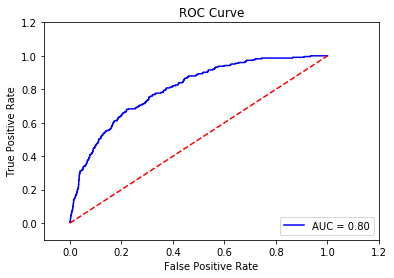

0.2898203592814371 0.2227625831287468 0.22021357018040175


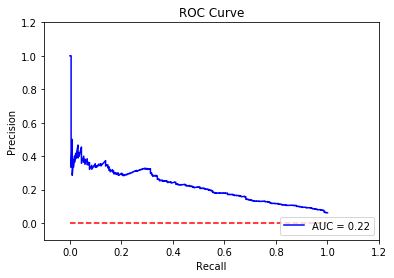

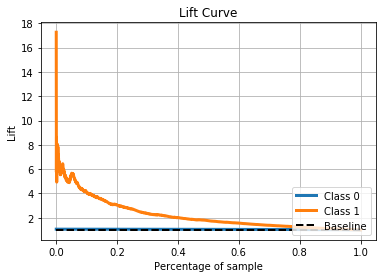

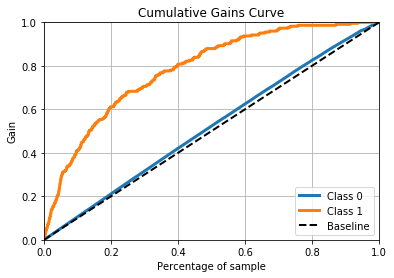

In [27]:
# Model Performance Metrics # 

y_predict = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print ("Accuracy is:", accuracy_score(y_test, y_predict))
print ("Precision:", sklearn.metrics.precision_score(y_test, y_predict))
print ("Recall:", sklearn.metrics.recall_score(y_test, y_predict))

#Confusion Matrix
print (pandas.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['True Negative', 'True Positive']
))
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print (tn, fp, fn, tp)

#Finding AUC and plotting ROC curve for positive class
y_proba_new = []
for i in y_proba:
    y_proba_new.append(i[1])
y_proba_new = np.array(y_proba_new)

y_test_new = []

y_test_new = y_test["CustomerAdd.x"]
y_test_new = np.array(y_test_new)

# Writing out the probabilities of the test set for lift calculation #
row_index = np.array(y_test.index)
test_tpids = []
for index in row_index:
    test_tpids.append(training_examples_tpid.iloc[index]["FinalTPID"])


test_tpids = pandas.DataFrame(test_tpids) 
print (test_tpids)

#Add probability of prediction 
prob0 = []
prob1 = []
for prob in y_proba:
    prob0.append(prob[0])
    prob1.append(prob[1])
    #max_prob = np.max(prob)
    #final_prob.append(max_prob)

#print (prob0)
#print (prob1)    
test_tpids["Probability0"] = prob0
test_tpids["Probability1"] = prob1

test_tpids.to_csv("C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Modeling\\ModelOutputTraining.csv", sep=',')


# AUC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_new, y_proba_new)
roc_auc = auc(false_positive_rate, true_positive_rate)


#Plotting
plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Precision - Recall Curve 

precision, recall, thresholds = precision_recall_curve(y_test_new, y_proba_new)
#auc = auc(recall, precision)
f1 = f1_score(y_test, y_predict)
ap = average_precision_score(y_test_new, y_proba_new)
auc = auc(recall, precision)
print (f1, ap, auc)

plt.title('ROC Curve')
plt.plot(recall, precision, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,0],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

import scikitplot as skplt
skplt.metrics.plot_lift_curve(y_true = y_test_new, y_probas = y_proba)
skplt.metrics.plot_cumulative_gain(y_test_new, y_proba)


In [159]:
import pickle

filename = 'C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Modeling\\Tries\\Model_best3.sav'
pickle.dump(clf, open(filename, 'wb')) #6000, 10000, voting classifier 

In [21]:
#Scoring with final model

testing_examples = pandas.read_csv("C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Data\\Features\\Scoring\\AllFeaturesv4.csv")
testing_examples = testing_examples.drop('ym', axis=1)
testing_examples_tpid = testing_examples[["FinalTPID"]]
testing_examples = testing_examples.drop('FinalTPID', axis=1)

print (selected_columns)
print (len(selected_columns))

testing_examples_new = testing_examples[selected_columns]


test_predict = clf.predict(testing_examples_new)
test_proba = clf.predict_proba(testing_examples_new)


# print (test_predict)
# print (test_proba)

#Add predicted label 
testing_examples_tpid["Predicted"] = test_predict

print (test_proba)
#Add probability of prediction 
prob0 = []
prob1 = []
for prob in test_proba:
    prob0.append(prob[0])
    prob1.append(prob[1])
    #max_prob = np.max(prob)
    #final_prob.append(max_prob)

#print (prob0)
#print (prob1)    
testing_examples_tpid["Probability0"] = prob0
testing_examples_tpid["Probability1"] = prob1

testing_examples_tpid.to_csv("C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Modeling\\ModelOutput.csv", sep=',')


Index(['WindowsCoreNonM365EnterpriseMean', 'OnPremMean', 'GeoMapping',
       'WindowsCoreNonM365E3Mean', 'O365E3add', 'IsFastTrackTenant',
       'DesktopSubscription', 'OfficePaidAvailableUnits', 'IntuneEnabledPerc',
       'O365E3Trend', 'o365E3Perc', 'HasEMSSku',
       'WindowsCoreNonM365E3YoYChange', 'o365E4Perc', 'o365E12Perc',
       'IndustryMapping', 'EMSE3', 'HasM365SKUE3', 'AzureMean',
       'YammerEnabledPerc', 'EnterpriseMobilityCoreNonM365YoYChange',
       'ProplusUsageEnabledPerc', 'EMSPaidAvailableUnits',
       'IntuneUsagePaidPerc', 'EMSE3CaoTotalEMS', 'OfficePaidTotalPerc',
       'emse3perc', 'O365E4', 'HasWindowsSku', 'O365E4Mean',
       'Intune_configured_users', 'AIPUsageEnabledPerc',
       'O365E5SecurityAnalyticsMean', 'Intune_active_users', 'M365E3Mean',
       'EMSE3FuslTotalEMS', 'HasOfficeSKUE1', 'HasDynamicsSku', 'O365E4Trend',
       'O365E5Mean', 'o365e5Perc', 'WindowsPaidTotalPerc', 'AADPP2EnabledPerc',
       'IntuneClientMean', 'MobIdentity', 'MC